# Does negativity make success?

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf
import scipy

import warnings
warnings.filterwarnings("ignore")

#### Load the dataframe containing videos from 2019 and their features

This is a big file (860 MB) so we have stored it on Google Drive. Download it from the link below and storie it as `generated/2019/2019_videos_Typo_Emojis_NegWords_Sentiment_title_desc.parquet`. It was generated by the notebook `data_processing.ipynb`.

https://drive.google.com/file/d/1RmVSw2MBq0Ps0dwcTQjqZsDAuivXbUaZ/view?usp=share_link

In [2]:
filepath = 'generated/2019/2019_videos_Typo_Emojis_NegWords_Sentiment_title_desc.parquet'
videos = pd.read_parquet(filepath, engine='fastparquet')

## What is negativity?

### Small intro (examples with sia from vader)

# Is there something to investigate ?

The trending videos dataset is used to determine a treshold on views and likes to split our dataset in two: Successful and not successful videos.

In [4]:
#Loading of the trending datasets
usvideos_1718 = pd.read_csv('data/USvideos 2.csv')
usvideos_2022 = pd.read_csv('data/US_youtube_trending_data 2.csv')

#Processing of the datasets to concatenate them
usvideos_1718 = usvideos_1718.drop('video_error_or_removed', axis=1)
usvideos_2022 = usvideos_2022.drop('channelId', axis=1)
usvideos_2022.rename(columns = {'publishedAt':'publish_time','channelTitle':'channel_title', 'categoryId':'category_id', 'view_count':'views'}, inplace = True)

columns_titles = usvideos_2022.columns

columns_titles_bis = []
columns_titles_bis.append(columns_titles[0])
columns_titles_bis.append(columns_titles[5])
columns_titles_bis.append(columns_titles[1])
columns_titles_bis.append(columns_titles[3])
columns_titles_bis.append(columns_titles[4])
columns_titles_bis.append(columns_titles[2])
columns_titles_bis.append(columns_titles[6])
columns_titles_bis.append(columns_titles[7])
columns_titles_bis.append(columns_titles[8])
columns_titles_bis.append(columns_titles[9])
columns_titles_bis.append(columns_titles[10])
columns_titles_bis.append(columns_titles[11])
columns_titles_bis.append(columns_titles[12])
columns_titles_bis.append(columns_titles[13])
columns_titles_bis.append(columns_titles[14])
usvideos_1718.columns

usvideos_2022=usvideos_2022.reindex(columns=columns_titles_bis)



#Creation of the trend dataframe
df_trends = pd.concat(
    [usvideos_1718, usvideos_2022],
    axis=0,
    join="outer",
    ignore_index=True,
    keys=None,
    levels=None,
    names=None,
    verify_integrity=False,
    copy=True,
)

df_trends

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,"One year after the presidential election, John..."
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...
3,puqaWrEC7tY,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,2146,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,Today we find out if Link is a Nickelback amat...
4,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,I know it's been a while since we did this sho...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207534,o_oenl2Be-w,2022-11-18T00:00:00Z,Wizkid - 2 Sugar (feat. Ayra Starr) (Official ...,StarBoy TV,10,2022-11-11T19:14:33Z,Afrobeat|Hip Hop|Wizkid|Made In Lagos|Nigeria|...,2161075,75596,0,3227,https://i.ytimg.com/vi/o_oenl2Be-w/default.jpg,False,False,Wizkid - 2 Sugar (feat. Ayra Starr) (Official ...
207535,DWBaf5U6vQQ,2022-11-18T00:00:00Z,Alex Pereira Octagon Interview | UFC 281,UFC - Ultimate Fighting Championship,17,2022-11-13T06:21:30Z,ufc|mma|ultimate fighting championship|UFC 281...,1874052,28533,0,7066,https://i.ytimg.com/vi/DWBaf5U6vQQ/default.jpg,False,False,Newly crowned middleweight champion Alex Perei...
207536,1V1ZrKOeXic,2022-11-18T00:00:00Z,How Asian Parents Grocery Shop,Steven He,23,2022-11-11T19:13:00Z,Steven He|Comedy|Sketches|Funny|laugh|tntl|ski...,2034736,96623,0,4307,https://i.ytimg.com/vi/1V1ZrKOeXic/default.jpg,False,False,Go to https://establishedtitles.com/StevenHe a...
207537,SXrcyqCPu4E,2022-11-18T00:00:00Z,Rod Wave - Break My Heart (Official Video),RodWave,10,2022-11-10T05:00:08Z,rod wave|hunger games|hunger games 3|ptsd|ghet...,3554744,135813,0,4589,https://i.ytimg.com/vi/SXrcyqCPu4E/default.jpg,False,False,Pre-Save Rod Wave's New Project Jupiter Diarie...


In [5]:
#Determination of the tresholds
treshold_views = np.quantile(df_trends['views'], 0.4)
treshold_likes = np.quantile(df_trends['likes'], 0.4)

697505.0000000001

In [6]:
#Dataset of the successful videos
videos_success = videos.loc[(videos['view_count'] > treshold_views)]
videos_success = videos_success.loc[(videos_success['like_count'] > treshold_likes)]



,categories,channel_id,crawl_date,dislike_count,display_id,duration,like_count,upload_date,view_count,count_words_title,...,count_negative_emojis_title,count_upper_words_title,count_excl_marks_title,count_upper_words_description,count_excl_marks_description,count_negative_emojis_description,sia_negative_description,sia_neutral_description,sia_positive_description,sia_compound_description
47,People & Blogs,UCzWmWTPCafQRNl9q9Y53AfQ,2019-11-17 05:07:30.405938,613,BDnF-EgqAGw,398,49464,2019-02-05,1142835,8,...,0,1,0,0,0,0,0.291,0.485,0.223,-0.1779
48,People & Blogs,UCzWmWTPCafQRNl9q9Y53AfQ,2019-11-17 05:07:30.959894,588,wrTIXbQED80,375,32726,2019-01-31,819654,4,...,0,0,0,0,0,0,0.000,1.000,0.000,0.0000
49,People & Blogs,UCzWmWTPCafQRNl9q9Y53AfQ,2019-11-17 05:07:31.467288,1177,uyWL0ZWibyU,335,86222,2019-01-22,2159837,4,...,0,0,0,0,0,0,0.093,0.659,0.249,0.6369
50,People & Blogs,UCzWmWTPCafQRNl9q9Y53AfQ,2019-11-17 05:07:31.948318,673,yd7d51AgSso,319,30596,2019-01-15,736707,4,...,0,0,0,0,0,0,0.000,0.597,0.403,0.7968
51,People & Blogs,UCzWmWTPCafQRNl9q9Y53AfQ,2019-11-17 05:07:32.579907,991,-Ia18bqO-9w,367,75504,2019-01-09,1636316,4,...,0,0,0,0,0,0,0.000,0.784,0.216,0.2960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12722465,News & Politics,UCrwE8kVqtIUVUzKui2WVpuQ,2019-11-01 23:40:14.207309,13759,-6tb2e8o9P4,5530,166341,2019-05-04,6563179,10,...,0,2,0,0,1,0,0.000,1.000,0.000,0.0000
12722777,News & Politics,UCrwE8kVqtIUVUzKui2WVpuQ,2019-11-01 23:38:37.982711,1700,eyfxhuqlQYU,12707,31815,2019-09-22,1068786,10,...,0,2,0,2,1,0,0.000,1.000,0.000,0.0000
12723042,News & Politics,UCrwE8kVqtIUVUzKui2WVpuQ,2019-11-01 23:38:42.845914,2606,A-2b0SVFCog,7627,35683,2019-08-14,1970503,18,...,0,1,0,1,1,0,0.000,1.000,0.000,0.0000
12723069,News & Politics,UCrwE8kVqtIUVUzKui2WVpuQ,2019-11-01 23:38:46.554592,3916,PZ0m1EmpndU,2411,67373,2019-08-08,2462660,12,...,0,1,0,1,1,0,0.000,1.000,0.000,0.0000


In [7]:
#Dataset of the not successful videos
new_videos = videos.drop(videos_success.index)

The two dataset need to be modified in order to plot the comparison

In [8]:

sia_neg_title_success = videos_success[['sia_negative_title', 'categories']]
sia_neg_description_success = videos_success[['sia_negative_description', 'categories']]


sia_neg_title = new_videos[['sia_negative_title', 'categories']]
sia_neg_description = new_videos[['sia_negative_description', 'categories']]



Construction of the negative title success dataset

In [9]:
neg_title_suc = ['Negative sentiment in title']
sia_bool_neg_title_suc = ['successful']

neg_title_suc = neg_title_suc*len(sia_neg_title_success)
sia_bool_neg_title_suc = sia_bool_neg_title_suc*len(sia_neg_title_success)
neg_title_suc_cat = sia_neg_title_success['categories']
sia_neg_title_success = sia_neg_title_success['sia_negative_title']



In [10]:


sia_neg_title_success_values = sia_neg_title_success.values
sia_neg_title_success = sia_neg_title_success_values.tolist()



In [11]:
#Creation of the negative title success dataset
data_given = {'Type of sentiment': neg_title_suc, 'SIA value': sia_neg_title_success, "Video's succes": sia_bool_neg_title_suc, 'categories':neg_title_suc_cat}

neg_title_suc_df = pd.DataFrame(data = data_given)


Construction of the negative title not success dataset

In [12]:
neg_title = ['Negative sentiment in title']
sia_bool_neg_title = ['not successful']

neg_title = neg_title*len(sia_neg_title)
sia_bool_neg_title = sia_bool_neg_title*len(sia_neg_title)
neg_title_cat = sia_neg_title['categories']
sia_neg_title = sia_neg_title['sia_negative_title']

In [13]:
sia_neg_title_values = sia_neg_title.values
sia_neg_title = sia_neg_title_values.tolist()


In [14]:
#Creation of the negative title success dataset
data_given = {'Type of sentiment': neg_title, 'SIA value': sia_neg_title, "Video's succes": sia_bool_neg_title, 'categories':neg_title_cat}

neg_title_df = pd.DataFrame(data = data_given)



In [15]:
#Total dataset for the title (merge success and not)
neg_title_total_df = neg_title_suc_df.append(neg_title_df, ignore_index=True)

Construction of the negative description success dataset

In [16]:
neg_description_suc = ['Negative sentiment in description']
sia_bool_neg_description_suc = ['successful']

neg_description_suc = neg_description_suc*len(sia_neg_description_success)
sia_bool_neg_description_suc = sia_bool_neg_description_suc*len(sia_neg_description_success)
neg_description_suc_cat = sia_neg_description_success['categories']
sia_neg_description_success = sia_neg_description_success['sia_negative_description']

In [17]:
sia_neg_description_success_values = sia_neg_description_success.values
sia_neg_description_success = sia_neg_description_success_values.tolist()

In [18]:
#Creation of the negative description success dataset
data_given = {'Type of sentiment': neg_description_suc, 'SIA value': sia_neg_description_success, "Video's succes": sia_bool_neg_description_suc, 'categories':neg_description_suc_cat}

neg_description_suc_df = pd.DataFrame(data = data_given)


,Type of sentiment,SIA value,Video's succes,categories
47,Negative sentiment in description,0.291,successful,People & Blogs
48,Negative sentiment in description,0.000,successful,People & Blogs
49,Negative sentiment in description,0.093,successful,People & Blogs
50,Negative sentiment in description,0.000,successful,People & Blogs
51,Negative sentiment in description,0.000,successful,People & Blogs
...,...,...,...,...
12722465,Negative sentiment in description,0.000,successful,News & Politics
12722777,Negative sentiment in description,0.000,successful,News & Politics
12723042,Negative sentiment in description,0.000,successful,News & Politics
12723069,Negative sentiment in description,0.000,successful,News & Politics


Construction of the negative description not success dataset

In [19]:
neg_description = ['Negative sentiment in description']
sia_bool_neg_description = ['not successful']

neg_description = neg_description*len(sia_neg_description)
sia_bool_neg_description = sia_bool_neg_description*len(sia_neg_description)



In [20]:

neg_description_cat = sia_neg_description['categories']
sia_neg_description = sia_neg_description['sia_negative_description']

In [21]:
sia_neg_description_values = sia_neg_description.values
sia_neg_description = sia_neg_description_values.tolist()

In [22]:
#Creation of the negative description not success dataset
data_given = {'Type of sentiment': neg_description, 'SIA value': sia_neg_description, "Video's succes": sia_bool_neg_description, 'categories':neg_description_cat}

neg_description_df = pd.DataFrame(data = data_given)


,Type of sentiment,SIA value,Video's succes,categories
0,Negative sentiment in description,0.000,not successful,Sports
1,Negative sentiment in description,0.000,not successful,Sports
2,Negative sentiment in description,0.047,not successful,Sports
3,Negative sentiment in description,0.000,not successful,Sports
4,Negative sentiment in description,0.033,not successful,Sports
...,...,...,...,...
12723119,Negative sentiment in description,0.000,not successful,News & Politics
12723120,Negative sentiment in description,0.000,not successful,News & Politics
12723121,Negative sentiment in description,0.000,not successful,News & Politics
12723122,Negative sentiment in description,0.000,not successful,News & Politics


In [23]:
#Total dataset for the description (merge success and not)
neg_description_total_df = neg_description_suc_df.append(neg_description_df, ignore_index=True)



,Type of sentiment,SIA value,Video's succes,categories
0,Negative sentiment in description,0.291,successful,People & Blogs
1,Negative sentiment in description,0.000,successful,People & Blogs
2,Negative sentiment in description,0.093,successful,People & Blogs
3,Negative sentiment in description,0.000,successful,People & Blogs
4,Negative sentiment in description,0.000,successful,People & Blogs
...,...,...,...,...
12723119,Negative sentiment in description,0.000,not successful,News & Politics
12723120,Negative sentiment in description,0.000,not successful,News & Politics
12723121,Negative sentiment in description,0.000,not successful,News & Politics
12723122,Negative sentiment in description,0.000,not successful,News & Politics


In [24]:
#Creation of the complete dataset to be plot
neg_total_df = neg_title_total_df.append(neg_description_total_df, ignore_index=True)


Text(0.5, 1.0, 'Difference in the SIA value in the title depending on the succes of the video')

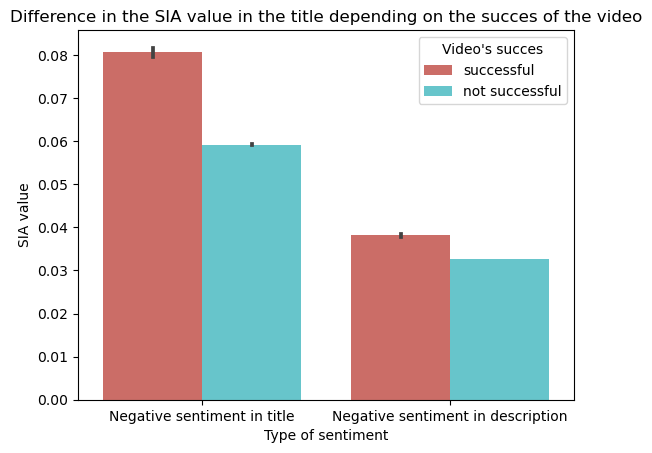

In [27]:
sns.barplot(data=neg_total_df, x="Type of sentiment", y="SIA value", hue="Video's succes", color = 'blue', palette = 'hls')
plt.title('Difference in the SIA value in the title depending on the succes of the video')

## Regression analysis [[Djian]]

### Overall

try description and title (look at R to find what is best) [[Djian: description is better]]

In [3]:
def print_regression(data, formula):
    model = smf.ols(formula=formula, data=data)
    np.random.seed(2)
    results = model.fit()
    print(results.summary())

In [4]:
# Remove videos where 'like_count' is NaN
videos = videos[videos['like_count'].isna() == False]

# Convert some rows to float
videos['like_count'] = videos['like_count'].astype(float)
videos['dislike_count'] = videos['dislike_count'].astype(float)
videos['view_count'] = videos['view_count'].astype(float)

# New columns for the log of the counts (+1 so that the log is always defined)
videos['log_view_count'] = np.log(videos['view_count'] + 1)
videos['log_like_count'] = np.log(videos['like_count'] + 1)
videos['log_dislike_count'] = np.log(videos['dislike_count'] + 1)

In [5]:
success_factors = ['log_view_count', 'log_like_count', 'log_dislike_count']


def regression_formula(success_factor):
    f = f'{success_factor} ~ '
    f += 'sia_negative_description ' 
    f += '+ sia_positive_description '
    f += '+ sia_neutral_description '
    return f


formulas = [regression_formula(s) for s in success_factors]

for f in formulas:
    print(f'Regression analysis for formula \n{f}')
    print_regression(data=videos, formula=f)
    print('')
    print('')

Regression analysis for formula 
log_view_count ~ sia_negative_description + sia_positive_description + sia_neutral_description 
                            OLS Regression Results                            
Dep. Variable:         log_view_count   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                 7.945e+04
Date:                Fri, 23 Dec 2022   Prob (F-statistic):               0.00
Time:                        11:28:41   Log-Likelihood:            -2.9834e+07
No. Observations:            12432558   AIC:                         5.967e+07
Df Residuals:                12432554   BIC:                         5.967e+07
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025 

### By category

In [6]:
# Find the categories
categories = set(videos['categories'].values)
categories.remove(None)

In [7]:
regression_for_success_factor = dict()

for success_factor in success_factors:
    f = regression_formula(success_factor)
    
    results_params_f = dict()

    for category in categories:
        videos_category = videos[videos['categories'] == category]
        model = smf.ols(formula=f, data=videos_category)
        np.random.seed(2)
        results = model.fit()
        results_params_f[category] = pd.concat([results.params, results.pvalues], keys=['parameter', 'p-value'])

    df_regression = pd.DataFrame(results_params_f).transpose()
    
    regression_for_success_factor[success_factor] = df_regression

In [8]:
def plot_regression(df_regression):
    
    df_reg = df_regression.copy()
    
    # Drop p-values and `Intercept`, remove index
    df_reg = df_reg['parameter']
    df_reg = df_reg.drop('Intercept', axis=1)
    df_reg = df_reg.reset_index()

    # Plot
    fig, ax = plt.subplots(figsize=(9, 6))
    plt.scatter(x=df_reg['index'], y=df_reg['sia_negative_description'], marker='$:($', color='crimson', s=50)
    plt.scatter(x=df_reg['index'], y=df_reg['sia_neutral_description'],  marker='$:|$', color='gray', s=50)
    plt.scatter(x=df_reg['index'], y=df_reg['sia_positive_description'],  marker='$:)$', color='dodgerblue', s=50)
    plt.xticks(rotation=90)
    plt.ylabel('log_count')
    plt.show()

Linear regression for log_view_count


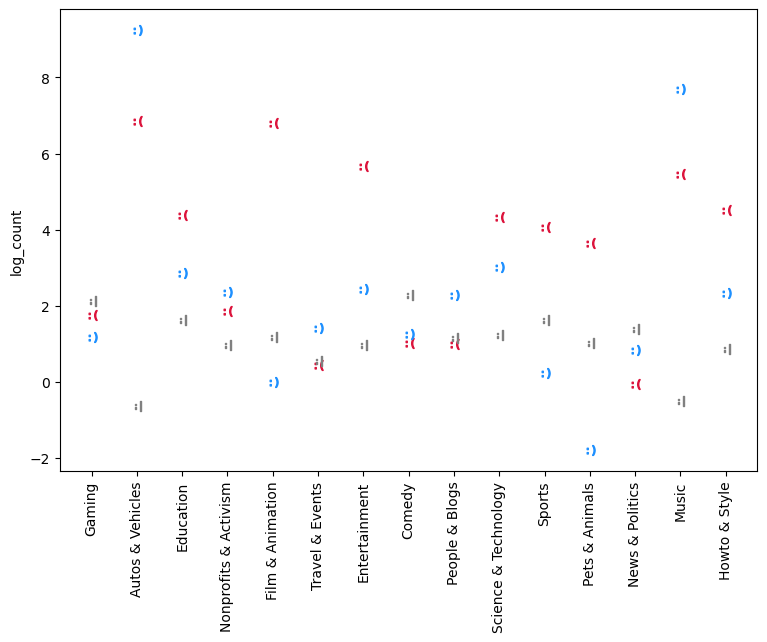


Linear regression for log_like_count


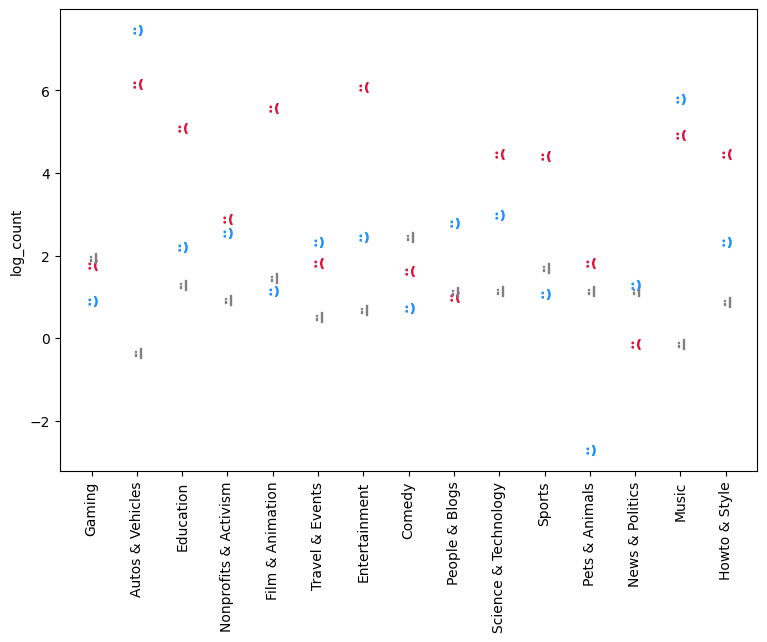


Linear regression for log_dislike_count


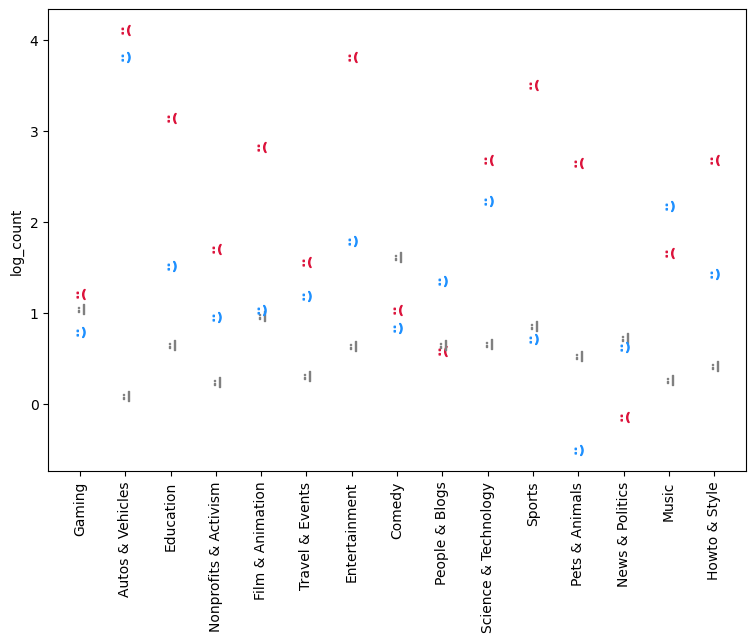

In [9]:
# Plot the regression parameters for various success factors

for success_f in success_factors:
    print(f'Linear regression for {success_f}')
    plot_regression(regression_for_success_factor[success_f])
    print('')

In [10]:
# Alternative: seaborn plot
'''
# Colors for the plot
palette_sentiment = {
    'sia_negative_description': 'crimson',
    'sia_neutral_description': 'gray',
    'sia_positive_description': 'dodgerblue',
    'Intercept': 'black'

}

# Drop p-values and `Intercept`, remove index
df_regression = df_regression['parameter']
df_regression = df_regression.drop('Intercept', axis=1)
df_regression = df_regression.reset_index()

# Convert the dataframe to long form, for seaborn plot
df_regression_melt = df_regression.melt('index', var_name='sentiment_type', value_name='sentiment_value')

# Plot
sns.scatterplot(
    data=df_regression_melt, 
    x='index', 
    y='sentiment_value', 
    hue='sentiment_type',
    s=40,
    marker='D',
    palette=palette_sentiment,
    #aspect=2,
    #jitter=False,  # for vertically aligned datapoints in each category
    alpha=0.8
)
plt.xticks(rotation=90)
plt.show()
'''
' '

' '

Creation of the interactive plot for the log view count depending on the sia

In [12]:
df_reg = regression_for_success_factor['log_view_count'].copy()
    
# Drop p-values and `Intercept`, remove index
df_reg = df_reg['parameter']
df_reg = df_reg.drop('Intercept', axis=1)
df_reg = df_reg.reset_index()



In [13]:
from jupyter_dash import JupyterDash
import dash_html_components as html
import dash_core_components as dcc
import plotly.graph_objs as go
import plotly.express as px
import dash
import math
from dash import Dash, dcc, html, Input, Output
import plotly.express as px

In [14]:
app = JupyterDash(__name__)


app.layout = html.Div([
    html.H4('Difference in the SIA value in the title depending on the succes of the video'),
    dcc.Dropdown(
        id="dropdown",
        options=['People & Blogs', 'Science & Technology', 'Gaming',
       'Film & Animation', 'News & Politics', 'Howto & Style', 'Music',
       'Entertainment', 'Education', 'Comedy', 'Travel & Events',
       'Sports', 'Autos & Vehicles', 'Pets & Animals',
       'Nonprofits & Activism'],
        value="People & Blogs",
        clearable=False,
    ),
    dcc.Graph(id="graph"),
])


@app.callback(
    Output("graph", "figure"), 
    Input("dropdown", "value"))
def update_bar_chart(cat):
    df = df_reg # replace with your own data source
    
    mask = df["index"] == cat
    
    inter = df_reg[mask]
    inter_dic = {'Sentiment': ['sia_negative_description', 'sia_positive_description', 'sia_neutral_description'], 'Value': [inter['sia_negative_description'].values[0], inter['sia_positive_description'].values[0], inter['sia_neutral_description'].values[0]]}
    inter_df = pd.DataFrame(data= inter_dic)

    fig = px.bar(inter_df, x="Sentiment", y="Value", barmode='group')
    return fig


app.run_server(debug = True,port=8050)

Dash app running on http://127.0.0.1:8050/


## Evolution of channels with negativity [[Victor]]

## What does successful negativity look like?

### Most used words: the vocabulary of videos that are negative and successful (for different categories) [[Maj]]

Make 'histogram' of words in title/desc for videos that are very negative and have lots of success (maybe do it for each category). Example:

https://ldrame21.github.io/metoo-media-impact/#data-story-title

### Try to extract topics from negative and successful videos